In [1]:
import os
from muscima.io import parse_cropobject_list

# Change this to reflect wherever your MUSCIMA++ data lives
CROPOBJECT_DIR = r'MUSCIMA-pp_v1.0/v1.0/data/cropobjects_manual'

cropobject_fnames = [os.path.join(CROPOBJECT_DIR, f) for f in os.listdir(CROPOBJECT_DIR)]
docs = [parse_cropobject_list(f) for f in cropobject_fnames]

In [2]:
# Bear in mind that the outlinks are integers, only valid within the same document.
# Therefore, we define a function per-document, not per-dataset.
def extract_notes_from_doc(cropobjects):
    cnt = 0
    """Finds all ``(full-notehead, stem)`` pairs that form
    quarter or half notes. Returns two lists of CropObject tuples:
    one for quarter notes, one of half notes.

    :returns: quarter_notes, half_notes
    """
    _cropobj_dict = {c.objid: c for c in cropobjects}

    notes = []
    obj = []
    obj2 = []
    for c in cropobjects:
        cnt+=1
        if (c.clsname == 'notehead-full') or (c.clsname == 'notehead-empty'):
            _has_stem = False
            _has_beam_or_flag = False
            stem_obj = None
            for o in c.outlinks:
                _o_obj = _cropobj_dict[o]
                obj.append(_o_obj.clsname)
                if _o_obj.clsname == 'stem':
                    _has_stem = True
                    stem_obj = _o_obj
                elif _o_obj.clsname == 'beam':
                    _has_beam_or_flag = True
                elif _o_obj.clsname.endswith('flag'):
                    _has_beam_or_flag = True
            if _has_stem and (not _has_beam_or_flag):
                # We also need to check against quarter-note chords.
                # Stems only have inlinks from noteheads, so checking
                # for multiple inlinks will do the trick.
                if len(stem_obj.inlinks) == 1:
                    notes.append((c, stem_obj))
                    
    quarter_notes = [(n, s) for n, s in notes if n.clsname == 'notehead-full']
    half_notes = [(n, s) for n, s in notes if n.clsname == 'notehead-empty']
        
    return quarter_notes, half_notes

qns_and_hns = [extract_notes_from_doc(cropobjects) for cropobjects in docs]

In [3]:
import itertools
qns = list(itertools.chain(*[qn for qn, hn in qns_and_hns]))
hns = list(itertools.chain(*[hn for qn, hn in qns_and_hns]))

len(qns), len(hns)

(4290, 1199)

In [4]:
qns[0]

(<muscima.cropobject.CropObject at 0x2457f332be0>,
 <muscima.cropobject.CropObject at 0x2457f4101d0>)

In [5]:
import numpy

def get_image(cropobjects, margin=1):
    """Paste the cropobjects' mask onto a shared canvas.
    There will be a given margin of background on the edges."""

    # Get the bounding box into which all the objects fit
    top = min([c.top for c in cropobjects])
    left = min([c.left for c in cropobjects])
    bottom = max([c.bottom for c in cropobjects])
    right = max([c.right for c in cropobjects])

    # Create the canvas onto which the masks will be pasted
    height = bottom - top + 2 * margin
    width = right - left + 2 * margin
    canvas = numpy.zeros((height, width), dtype='uint8')

    for c in cropobjects:
        # Get coordinates of upper left corner of the CropObject
        # relative to the canvas
        _pt = c.top - top + margin
        _pl = c.left - left + margin
        # We have to add the mask, so as not to overwrite
        # previous nonzeros when symbol bounding boxes overlap.
        canvas[_pt:_pt+c.height, _pl:_pl+c.width] += c.mask

    canvas[canvas > 0] = 1
    return canvas

In [6]:
qn_images = [get_image(qn) for qn in qns]
hn_images = [get_image(hn) for hn in hns]

In [7]:
qn_images[1].shape

(84, 28)

In [8]:
import matplotlib.pyplot as plt

def show_mask(mask):
    plt.imshow(mask, cmap='gray', interpolation='nearest')
    plt.show()

def show_masks(masks, row_length=5):
    n_masks = len(masks)
    n_rows = n_masks // row_length + 1
    n_cols = min(n_masks, row_length)
    fig = plt.figure()
    for i, mask in enumerate(masks):
        plt.subplot(n_rows, n_cols, i+1)
        plt.imshow(mask, cmap='gray', interpolation='nearest')
    # Let's remove the axis labels, they clutter the image.
    for ax in fig.axes:
        ax.set_yticklabels([])
        ax.set_xticklabels([])
        ax.set_yticks([])
        ax.set_xticks([])
    plt.show()

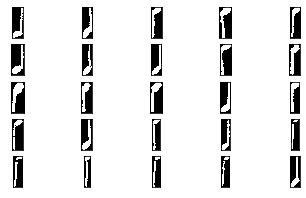

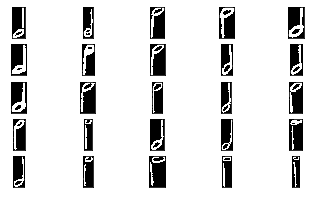

In [9]:
show_masks(qn_images[:25])
show_masks(hn_images[:25])

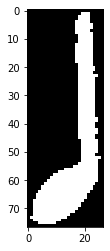

In [10]:
show_mask(qn_images[16])

In [12]:
import numpy as np
np.shape(hn_images[10])

(64, 32)

In [13]:
from skimage.transform import resize

qn_resized = [resize(qn, (200, 64)) for qn in qn_images]
hn_resized = [resize(hn, (200, 64)) for hn in hn_images]


# And re-binarize, to compensate for interpolation effects
for qn in qn_resized:
    qn[qn > 0] = 1
for hn in hn_resized:
    hn[hn > 0] = 1

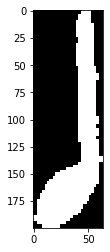

In [14]:
show_mask(qn_resized[16])

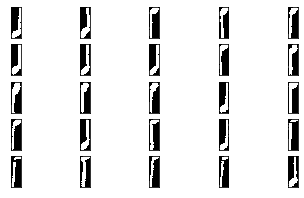

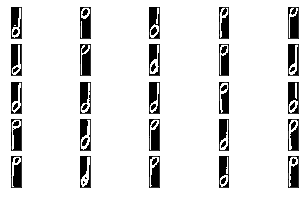

In [15]:
show_masks(qn_resized[:25])
show_masks(hn_resized[-25:])

In [16]:
# Randomly pick an equal number of quarter-notes.
n_hn = len(hn_resized)
import random
random.shuffle(qn_resized)
qn_selected = qn_resized[:n_hn]

In [17]:
Q_LABEL = 1
H_LABEL = 0

qn_labels = [Q_LABEL for _ in qn_selected]
hn_labels = [H_LABEL for _ in hn_resized]



notes = qn_selected + hn_resized
labels = qn_labels + hn_labels

In [18]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(
    notes, labels, test_size=0.25, random_state=42,
    stratify=labels)

In [19]:
from PIL import Image
bb = Image.open('qn4.png')

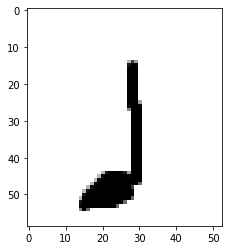

In [20]:
plt.imshow(bb)

In [21]:
b2 = np.array(bb)

In [22]:
chk = ((b2 == 255).all(-1)).astype(int)

In [23]:
for idx,a in enumerate(chk):
    for idx2,b in enumerate(a):
        if b == 1:
            chk[idx][idx2] = 0
        else :
            chk[idx][idx2] = 1

In [24]:
np.shape(chk)

(59, 53)

In [25]:
chk

array([[0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       ...,
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0]])

In [26]:
b2 = resize(chk, (40,50))

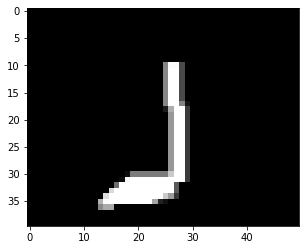

In [27]:
show_mask(b2)

In [28]:
for a in b2:
    a[a>0] = 1

In [29]:
X_train = np.array(X_train)

In [30]:
X_train = X_train.reshape(X_train.shape[0],X_train.shape[1],X_train.shape[2],1)

In [31]:
X_train.shape[3]

1

In [32]:
y_train = np.array(y_train)

In [33]:
from tensorflow.keras.models import Sequential
from tensorflow.keras import optimizers
from tensorflow.keras.layers import Dense, Activation, Flatten, Conv2D, MaxPooling2D

def basic_cnn():
    model = Sequential()

    model.add(Conv2D(input_shape = (X_train.shape[1], X_train.shape[2], X_train.shape[3]), filters = 50, kernel_size = (3,3), strides = (1,1), padding = 'same'))
    model.add(Activation('relu'))
    model.add(MaxPooling2D(pool_size = (2,2)))

    # prior layer should be flattend to be connected to dense layers
    model.add(Flatten())
    # dense layer with 50 neurons
    model.add(Dense(50, activation = 'relu'))
    # final layer with 10 neurons to classify the instances
    model.add(Dense(1, activation = 'sigmoid'))

    adam = optimizers.Adam(lr = 0.001)
    
    return model

In [34]:
model = basic_cnn()

In [35]:
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 200, 64, 50)       500       
_________________________________________________________________
activation (Activation)      (None, 200, 64, 50)       0         
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 100, 32, 50)       0         
_________________________________________________________________
flatten (Flatten)            (None, 160000)            0         
_________________________________________________________________
dense (Dense)                (None, 50)                8000050   
_________________________________________________________________
dense_1 (Dense)              (None, 1)                 51        
Total params: 8,000,601
Trainable params: 8,000,601
Non-trainable params: 0
______________________________________________

In [37]:
model.compile(optimizer = 'rmsprop',loss='binary_crossentropy', metrics='accuracy')
model.fit(X_train,y_train,epochs=10, batch_size = 20)

Epoch 1/10
90/90 [==============================] - 11s 124ms/step - loss: 0.3907 - accuracy: 0.8676
Epoch 2/10
90/90 [==============================] - 16s 173ms/step - loss: 0.0768 - accuracy: 0.9711
Epoch 3/10
90/90 [==============================] - 16s 180ms/step - loss: 0.0178 - accuracy: 0.9922
Epoch 4/10
90/90 [==============================] - 16s 173ms/step - loss: 0.0263 - accuracy: 0.9933
Epoch 5/10
90/90 [==============================] - 17s 191ms/step - loss: 0.0054 - accuracy: 0.9978
Epoch 6/10
90/90 [==============================] - 18s 202ms/step - loss: 3.3771e-04 - accuracy: 1.0000
Epoch 7/10
90/90 [==============================] - 18s 204ms/step - loss: 0.0012 - accuracy: 0.9994
Epoch 8/10
90/90 [==============================] - 18s 197ms/step - loss: 8.7920e-06 - accuracy: 1.0000
Epoch 9/10
90/90 [==============================] - 17s 193ms/step - loss: 0.0096 - accuracy: 0.9967
Epoch 10/10
90/90 [==============================] - 17s 186ms/step - loss: 1.1158e

In [38]:
X_test = np.array(X_test)
X_test = X_test.reshape(X_test.shape[0],X_test.shape[1],X_test.shape[2],1)

In [39]:
y_test_pred = model.predict(X_test)

In [40]:
y_pred = []
for i in y_test_pred:
    if i <0.5:
        y_pred.append(0)
    else :
        y_pred.append(1)

In [41]:
from sklearn.metrics import classification_report
print(classification_report(y_test, y_pred, target_names=['half', 'quarter']))

              precision    recall  f1-score   support

        half       1.00      0.95      0.97       300
     quarter       0.96      1.00      0.98       300

    accuracy                           0.97       600
   macro avg       0.98      0.98      0.97       600
weighted avg       0.98      0.97      0.97       600



In [42]:
def extract_data_from_doc(cropobjects):
    _cropobj_dict = {c.objid: c for c in cropobjects}
    notes = []

    for c in cropobjects:
        obj = []
        obj.append(c)
        for o in c.outlinks:
            obj.append(_cropobj_dict[o])
        obj = tuple(obj)
        notes.append(obj)
    return notes

In [43]:
def extract_notes_from_doc(cropobjects):
    
    _cropobj_dict = {c.objid: c for c in cropobjects}

    notes = []
    eight_notes = []
    sixteen_notes = []
    dot_notes = []
    dot_eight_notes = []
    dot_sixteen_notes = []
    for c in cropobjects:
       if (c.clsname == 'notehead-full') or (c.clsname == 'notehead-empty'):
            _has_stem = False
            _has_beam = False
            _has_8th_flag = False
            _has_16th_flag = False
            _has_dot = False
            stem_obj = None
            e_flag_obj = None
            s_flag_obj = None
            dot_obj = None
            for o in c.outlinks:
                _o_obj = _cropobj_dict[o]
                if _o_obj.clsname == 'stem':
                    _has_stem = True
                    stem_obj = _o_obj
                elif _o_obj.clsname == 'beam':
                    _has_beam = True
                elif _o_obj.clsname == '8th_flag':
                    _has_8th_flag = True
                    e_flag_obj = _o_obj
                elif _o_obj.clsname == '16th_flag':
                    _has_16th_flag = True
                    s_flag_obj = _o_obj
                elif _o_obj.clsname == 'duration-dot':
                    _has_dot = True
                    dot_obj = _o_obj
            if _has_stem and (not _has_beam):
                if len(stem_obj.inlinks) == 1:
                    if _has_dot:
                        if _has_8th_flag:
                            if _has_16th_flag:
                                dot_sixteen_notes.append((c, stem_obj, e_flag_obj, s_flag_obj, dot_obj))
                            else :
                                dot_eight_notes.append((c, stem_obj, e_flag_obj, dot_obj))
                        else :
                            dot_notes.append((c, stem_obj, dot_obj))
                    else :
                        if _has_8th_flag:
                            if _has_16th_flag:
                                sixteen_notes.append((c, stem_obj, e_flag_obj, s_flag_obj))
                            else :
                                eight_notes.append((c, stem_obj, e_flag_obj))
                        else :
                            notes.append((c, stem_obj))
    dot_quarter_notes = [(n, s, d) for n, s, d in dot_notes if n.clsname == 'notehead-full']
    dot_half_notes = [(n, s, d) for n, s, d in dot_notes if n.clsname == 'notehead-empty']
    quarter_notes = [(n, s) for n, s in notes if n.clsname == 'notehead-full']
    half_notes = [(n, s) for n, s in notes if n.clsname == 'notehead-empty']
    return quarter_notes, half_notes, eight_notes, sixteen_notes, dot_quarter_notes, dot_half_notes, dot_eight_notes, dot_sixteen_notes

In [44]:
notes = [extract_notes_from_doc(cropobjects) for cropobjects in docs]

In [45]:
qns = list(itertools.chain(*[qn for qn, hn, en, sn, d_qn, d_hn, d_en, d_sn in notes]))
hns = list(itertools.chain(*[hn for qn, hn, en, sn, d_qn, d_hn, d_en, d_sn in notes]))
ens = list(itertools.chain(*[en for qn, hn, en, sn, d_qn, d_hn, d_en, d_sn in notes]))
sns = list(itertools.chain(*[sn for qn, hn, en, sn, d_qn, d_hn, d_en, d_sn in notes]))
d_qns = list(itertools.chain(*[d_qn for qn, hn, en, sn, d_qn, d_hn, d_en, d_sn in notes]))
d_hns = list(itertools.chain(*[d_hn for qn, hn, en, sn, d_qn, d_hn, d_en, d_sn in notes]))
d_ens = list(itertools.chain(*[d_en for qn, hn, en, sn, d_qn, d_hn, d_en, d_sn in notes]))
d_sns = list(itertools.chain(*[d_sn for qn, hn, en, sn, d_qn, d_hn, d_en, d_sn in notes]))

In [46]:
qn_images = [get_image(qn) for qn in qns]
hn_images = [get_image(hn) for hn in hns]
en_images = [get_image(en) for en in ens]
sn_images = [get_image(sn) for sn in sns]
d_qn_images = [get_image(d_qn) for d_qn in d_qns]
d_hn_images = [get_image(d_hn) for d_hn in d_hns]
d_en_images = [get_image(d_en) for d_en in d_ens]
d_sn_images = [get_image(d_sn) for d_sn in d_sns]

In [47]:
len(d_sns)

1

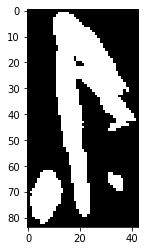

In [48]:
show_mask(d_sn_images[0])

In [458]:
def extract_data_from_doc(cropobjects):
    _cropobj_dict = {c.objid: c for c in cropobjects}
    notes = []

    for c in cropobjects:
        if c.clsname == 'beam':       
            obj = []
            obj.append(c)
            for o in c.outlinks:
                obj.append(_cropobj_dict[o])
            obj = tuple(obj)
            notes.append(obj)
    return notes

In [459]:
data = [extract_data_from_doc(cropobjects) for cropobjects in docs]
data = list(itertools.chain(*[d for d in data]))

data_images = [get_image(d) for d in data]

In [460]:
len(data_images)

6593

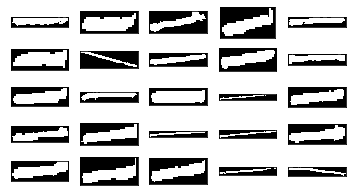

In [461]:
show_masks(data_images[:25])

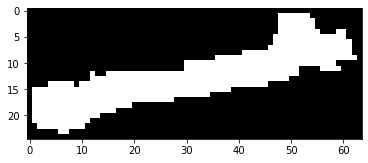

In [462]:
show_mask(data_images[2])

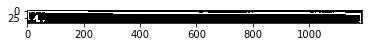

In [446]:
show_mask(data_images[0])

In [53]:
data[241]

(<muscima.cropobject.CropObject at 0x2457f384390>,)